# Valoración de opciones de compra europeas utilizando la fórmula Black-Scholes aplicada a acciones de Amazon

#### Por:
* Santiago Hincapie
* Sarah Henao
* Luisa Londoño

## Analisis cuantitativo
### Asunciones del modelo 
* European style option
* zero dividend
* log normality
* ignores leptokurtic or platykurtic behaviour
* constant volatility : Prueba de herostesadicidad condicional
* no arbitrage opportunity
* put/call parity all the time
* risk free interest rate is constant


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py # download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as off
import plotly.graph_objs as go
import plotly.figure_factory as FF
import statsmodels.stats.diagnostic as sm

#py.offline.init_notebook_mode(connected=True)

from scipy import stats
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv('../data/NASDAQ:AMZN.csv')
df.Dates = df.Dates.map(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [65]:
data = [go.Scatter(
            x=df.Dates,
            y=df.PX_LAST)]

layout = go.Layout(
    showlegend=False,
    title='Serie de Acciones de Amazon',
    xaxis=dict(title='Tiempo (días)'),
    yaxis=dict(title='Precio de la Acción (USD)'),
    annotations=[
        dict(
            x='2017-06-08',
            y=1010.27,
            xref='x',
            yref='y',
            text='Goldman Sachs',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x='2017-06-16',
            y=987.71,
            xref='x',
            yref='y',
            text='Whole Foods',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-50
        ),
        dict(
            x='2017-07-20',
            y=1028.7,
            xref='x',
            yref='y',
            text='Kenmore',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x='2017-07-26',
            y=1052.8,
            xref='x',
            yref='y',
            text='Trump',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x='2017-08-2',
            y=995.89,
            xref='x',
            yref='y',
            text='Energizer',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-45
        ),
        dict(
            x='2017-09-5',
            y=965.27,
            xref='x',
            yref='y',
            text="Kohl's",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x='2017-09-26',
            y=938.6,
            xref='x',
            yref='y',
            text='Carrefour',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-70
        ),
        dict(
            x='2017-10-03',
            y=957.1,
            xref='x',
            yref='y',
            text='Tokio',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-80
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='noticias')

In [4]:
py.iplot([go.Scatter(x=df.index, y=df.Returns)], 
         layout=go.Layout(title='Retornos instantáneos'),
         filename='noise')

In [6]:
df.Returns
py.iplot(FF.create_distplot([df.Returns],['returns'], bin_size=0.002), layout=go.Layout(showlegend=False))

In [41]:
sh = stats.shapiro(df.Returns)
jb = stats.jarque_bera(df.Returns)
ks = stats.kstest((df.Returns - np.mean(df.Returns))/np.std(df.Returns), cdf='norm')
ll = sm.kstest_normal(df.Returns)

t = [sh, jb, ks, ll]

test = pd.DataFrame(data={'Estadistico de prueba': [i[0] for i in t],
                          'p-value': [i[1] for i in t],
                           'Resultado': [i[1] > 0.05 for i in t]})
test.index = ['Shapiro-Wilk', 'Jarque–Bera', 'Kolmogorov-Smirnov', 'Lilliefors']
print(test.to_latex())

\begin{tabular}{lrlr}
\toprule
{} &  Estadistico de prueba &  Resultado &   p-value \\
\midrule
Shapiro-Wilk       &               0.978663 &       True &  0.053506 \\
Jarque–Bera        &               4.436505 &       True &  0.108799 \\
Kolmogorov-Smirnov &               0.050973 &       True &  0.914157 \\
Lilliefors         &               0.050039 &       True &  0.200000 \\
\bottomrule
\end{tabular}



# PACF
Otra hipotesis del modelo de black scholes, es que los datos provienen de un movimiento browniano geometrico, por lo cual, es necesario realizar un grafico de autocorrelacion parcial y en este ver la dependencia que posee la serie diferentes lags

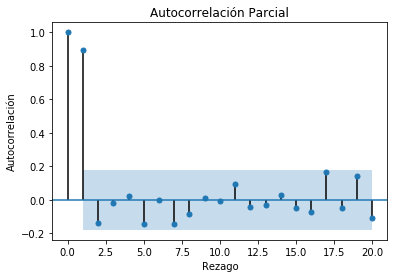

In [64]:
plot_pacf(df.PX_LAST, lags=20)
plt.xlabel('Rezago')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación Parcial')
plt.savefig('pacf.png', dpi=1000)

In [8]:
dt = 1/252 # Datos diarios
vsigma = np.sqrt(np.var(df.Returns)/dt)
print(vsigma)

S0 = df.PX_LAST.mean()
print(S0)

0.1726831558229783
982.3500833333334


## Diferencias finitas

In [3]:
%load_ext Cython

In [4]:
%%cython

cimport numpy as np
import numpy as np

def finite_difference(float r, float sigma, int K, int S_0,
                     int F_max, float dS, float T):
    """ Arbitrary Parameters
    r     : Tasa de interes libre de riesgo      # 0.05 
    sigma : Volatilidad                          # #
    K     : Precio de ejercicio                  # Cualquiera

    Initial Conditions
    S_0   : Valor de accion en tiempo actual     # 
    S_max : Cota superior de la accion           # 
    dS    : Tamaño de intervalos del precio      # 
    M     : Intervalos del precio                # 
    T     : Tiempo de muestreo                   # 
    N     : Intervalos del tiempo                # 
    dT    : Tamaños de intervalos del tiempo     # 
    """

    cdef int S_max = S_0 * F_max
    cdef Py_ssize_t M = int(S_max/dS)
    cdef float dT_tmp = (dS/(sigma*S_max))**2
    cdef Py_ssize_t N = int(np.ceil(T/dT_tmp))
    cdef float dT = T/N

    # Ponderación
    cdef np.ndarray[double] a, b, c, J
    a = np.zeros(M+1, dtype=np.float)
    b = np.zeros(M+1, dtype=np.float)
    c = np.zeros(M+1, dtype=np.float)
    J = np.arange(M+1, dtype=np.float)

    a = (dT/(1+r*dT)) * ((sigma**2 * J**2)/2 - (r * J/2))
    b = (dT/(1+r*dT)) * ((1/dT) - sigma**2 * J**2)
    c = (dT/(1+r*dT)) * ((sigma**2 * J**2)/2 + (r * J/2))

    cdef np.ndarray[double, ndim=2] F = np.zeros((N+1, M+1))
    
    # Condiciones de frontera
    F[:, 0] = max(-K, 0)
    F[N, :] = (J*dS - K).clip(min=0)
    F[:, M] = max(S_max - K, 0)

    # Llenar Malla
    cdef int i, j
    cdef bool 
    for i in range(N-1, -1, -1):
        for j in range(1, M):
            F[i, j] = a[j] * F[i+1, j-1] + b[j] * F[i+1, j] \
                      + c[j] * F[i+1, j+1]

    P = int(S_0/dS)
    FF = F[0, P]
    return F, FF, P

In [5]:
from scipy.stats import norm

def blsprice(r, v, K, S, T):
    # https://gist.github.com/carljohanrehn/4f20cc0433e10dc1c312
    d_1 = 1 / v / np.sqrt(T) * (np.log(S / K) + (r + v ** 2 / 2) * T)
    d_2 = d_1 - v * np.sqrt(T)
    return norm.cdf(d_1) * S - norm.cdf(d_2) * K * np.exp(-r * T)

#### parametros de prueba

In [6]:
r = 0.05
sigma = 0.7
K = 100
S_0 = 100
F = 2
dS = 5
dT = 1/12

In [7]:
BL = blsprice(r, sigma, K, S_0, dT)

In [8]:
%%time
mesh_1, FF1, P1 = finite_difference(r, sigma, K, S_0, F, 1, dT)
mesh_05, FF05, P05 = finite_difference(r, sigma, K, S_0, F, 0.5, dT)
mesh_01, FF01, P01 = finite_difference(r, sigma, K, S_0, F, 0.1, dT)
#mesh_005, FF005, P005 = finite_difference(r, sigma, K, S_0, F, 0.05, dT)

CPU times: user 3.94 s, sys: 962 ms, total: 4.9 s
Wall time: 4.89 s


In [19]:
print(FF1, FF05, FF01, BL)

8.239586081439338 8.243845072491997 8.275048692153245 8.240705226328195


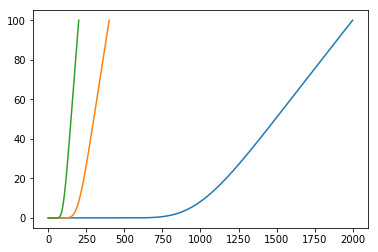

In [22]:
plt.plot(mesh_01[0, :])
plt.plot(mesh_05[0, :])
plt.plot(mesh_1[0, :])
plt.show()

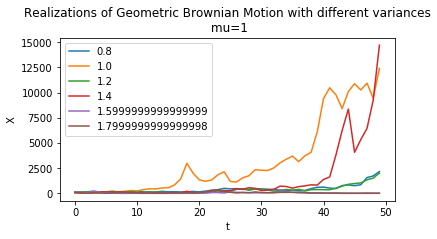

In [80]:
mu=1
n=50
dt=0.1
x0=100
x=pd.DataFrame()
np.random.seed(1)

for sigma in np.arange(0.8,2,0.2):
    step=np.exp((mu-sigma**2/2)*dt)*np.exp(sigma*np.random.normal(0,np.sqrt(dt),(1,n)))
    temp=pd.DataFrame(x0*step.cumprod())
    x=pd.concat([x,temp],axis=1)

x.columns=np.arange(0.8,2,0.2)
plt.plot(x)
plt.legend(x.columns)
plt.xlabel('t')
plt.ylabel('X')
plt.title('Realizations of Geometric Brownian Motion with different variances\n mu=1')
plt.show()

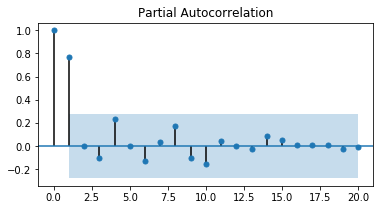

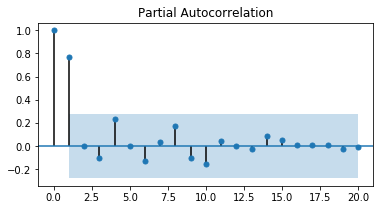

In [81]:
plot_pacf(x[0.8], lags=20)

In [82]:
step=np.exp((mu-np.sin(np.arange(50))**2/2)*dt)*np.exp(sigma*np.random.normal(0,np.sqrt(dt),(1,n)))
temp=pd.DataFrame(x0*step.cumprod())
x=pd.concat([x,temp],axis=1)

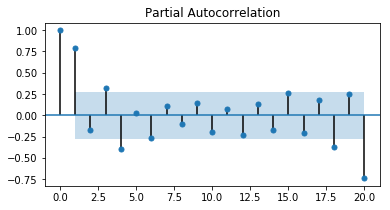

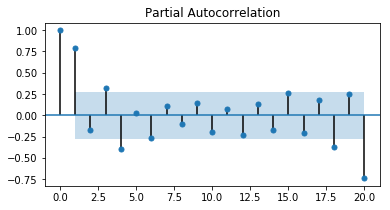

In [83]:
plot_pacf(x[0], lags=20)

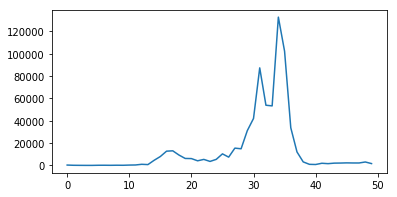

In [84]:
plt.plot(x[0])

True False True


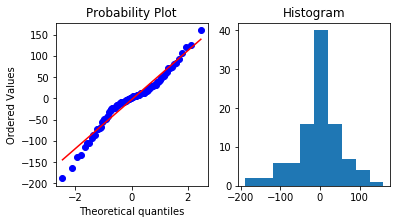

In [42]:
a = np.array([np.random.normal(0, i) for i in range(100)])

f, axarr = plt.subplots(1, 2)
axarr[1].hist(a)bb
axarr[1].set_title("Histogram")
stats.probplot(a, plot=axarr[0])
plt.rcParams["figure.figsize"] = (6, 3)
plt.savefig('plots/norm.png')

sh = stats.shapiro(df.Returns)
ks = stats.kstest(df.Returns, cdf='norm')
ad = stats.anderson(df.Returns)
da = stats.mstats.normaltest(df.Returns)

print(sh[1] > 0.05, ks[1] > 0.05, da[1] > 0.05)